## 1. IMPORTING LIBRARIES & LOADING DATA

In [291]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from IPython.display import display
from scipy.stats import chi2_contingency, ttest_ind


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visual style to match the sample
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully.")

Libraries imported successfully.


In [292]:
# Load the dataset
try:
    df = pd.read_csv('data/Telco-Customer-Churn.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("CSV not found. Place it in 'data/' or adjust the path.")


# Copy of raw data (useful for comparison)
df_raw = df.copy()


Dataset loaded successfully.


## 2. DATASET ANALYSIS

In [293]:
# Display first 5 rows
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [294]:
# Check data shape (Rows, Columns)
print(f"\nShape of dataset: {df.shape}")


Shape of dataset: (7043, 21)


In [295]:
# Check data types and existing nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [296]:
print("\nSummary statistics for numeric columns:")
print(df.describe())


Summary statistics for numeric columns:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [297]:
# Check for duplicates
dup_count = df.duplicated().sum()
print(f"\nDuplicate Rows: {dup_count}")



Duplicate Rows: 0


In [298]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 3. DATA CLEANING

In [299]:
# Replace blank strings with NaN
df = df.replace(r"^\s*$", np.nan, regex=True)

In [300]:
# Convert TotalCharges to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    missing_tc = df["TotalCharges"].isna().sum()
    print(f"Missing values in TotalCharges after conversion: {missing_tc}")

Missing values in TotalCharges after conversion: 11


In [301]:
# Impute missing TotalCharges
if "TotalCharges" in df.columns:
    median_tc = df["TotalCharges"].median()
    df["TotalCharges"].fillna(median_tc, inplace=True)
    print(f"Imputed missing TotalCharges with median = {median_tc:.2f}")

Imputed missing TotalCharges with median = 1397.47


In [302]:
# Remove non-informative identifier
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)
    print("Dropped 'customerID' column.")

Dropped 'customerID' column.


In [303]:
# Binary Yes/No columns to 0/1
binary_map = {"Yes": 1, "No": 0}
for col in df.columns:
    # Only map if column contains subset of Yes/No (ignoring NaNs)
    unique_vals = set(df[col].dropna().unique())
    if unique_vals and unique_vals <= {"Yes", "No"}:
        df[col] = df[col].map(binary_map)

In [304]:
# Ensure Churn is int
if 'Churn' in df.columns and df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map(binary_map)

In [305]:
# Ensure Churn is clearly numeric 0/1
if "Churn" in df.columns:
    if df["Churn"].dtype == "O":
        df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
    df["Churn"] = df["Churn"].astype(int)

In [306]:
print("\n CLEANED DATA (first 5 rows) ")
display(df.head())

print("\nMissing values after cleaning:")
print(df.isna().sum())


 CLEANED DATA (first 5 rows) 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1



Missing values after cleaning:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 4. EXPLORATORY DATA ANALYSIS

##### Univariate Distributions

In [307]:
# Statistical Summary of Numerical Columns
print("Statistical Summary (Numerical)")
display(df.describe())

Statistical Summary (Numerical)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2281.916928,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2265.270398,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,402.225000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [308]:
# Statistical Summary of Categorical Columns
print("\nStatistical Summary (Categorical)")
display(df.describe(include=['O']))


Statistical Summary (Categorical)


,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,3,3,3,3,3,3,3,3,3,4
top,Male,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check
freq,3555,3390,3096,3498,3088,3095,3473,2810,2785,3875,2365


In [309]:
# Check Unique Values for key categorical columns
# This helps us identify if there are any typos like "Yes" vs "yes"
print("\nUnique Values in 'PaymentMethod'")
print(df['PaymentMethod'].unique())

print("\nUnique Values in 'Contract'")
print(df['Contract'].unique())


Unique Values in 'PaymentMethod'
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Unique Values in 'Contract'
['Month-to-month' 'One year' 'Two year']



Churn Count (Target):
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Percentage:
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


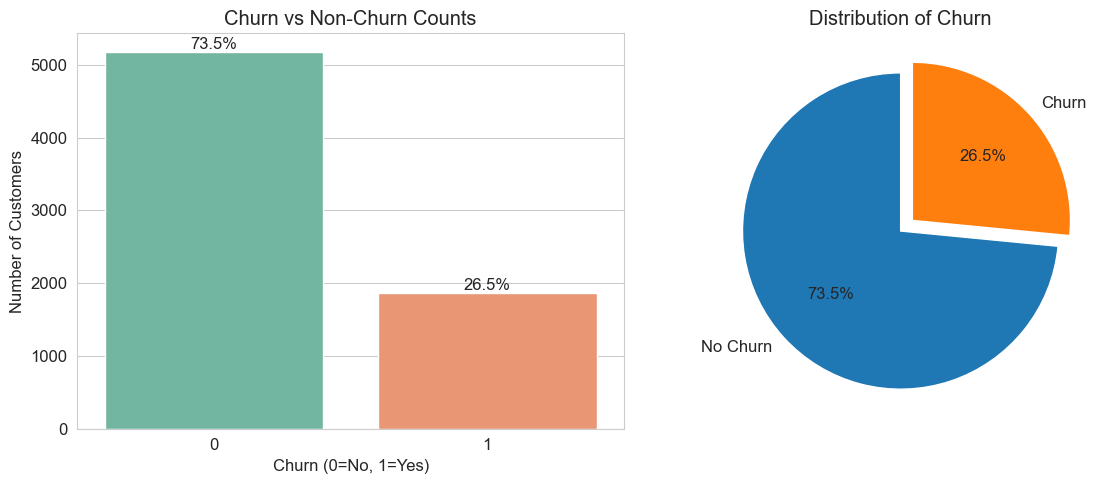

In [310]:
# Target Variable – Churn
if "Churn" in df.columns:
    print("\nChurn Count (Target):")
    print(df["Churn"].value_counts())

    print("\nChurn Percentage:")
    print((df["Churn"].value_counts(normalize=True) * 100).round(2))

    churn_counts = df["Churn"].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.countplot(data=df, x="Churn", ax=axes[0], palette="Set2")
    axes[0].set_title("Churn vs Non-Churn Counts")
    axes[0].set_xlabel("Churn (0=No, 1=Yes)")
    axes[0].set_ylabel("Number of Customers")

    total = len(df)
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(
            f"{100 * height / total:.1f}%",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
        )

    axes[1].pie(
        churn_counts,
        labels=["No Churn", "Churn"],  # assumes value_counts sorted 0,1
        autopct="%1.1f%%",
        startangle=90,
        explode=(0, 0.1),
    )
    axes[1].set_title("Distribution of Churn")

    plt.tight_layout()
    plt.show()

Observation: The dataset is imbalanced. Approximately 26.5% of customers churned, while 73.5% stayed.

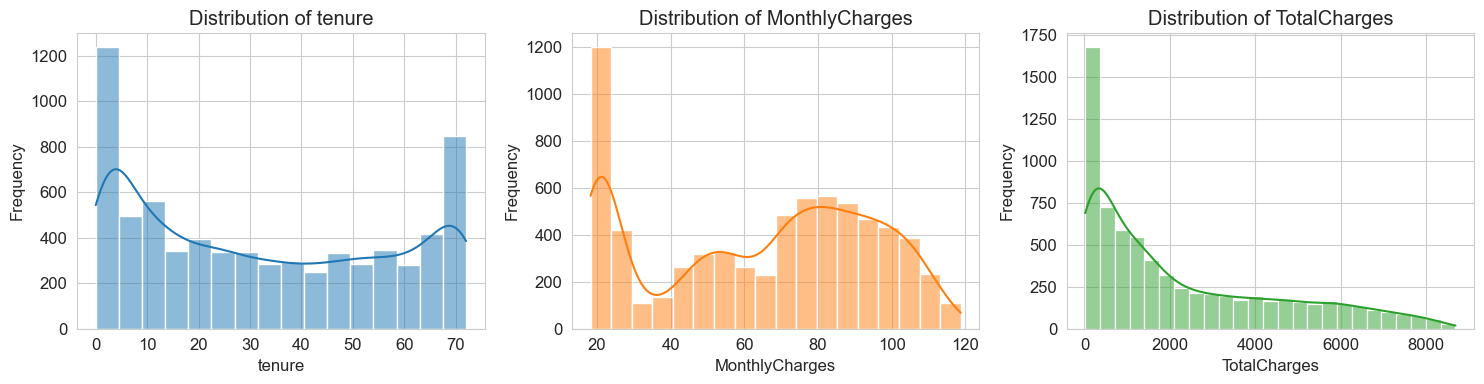

In [311]:
# Numeric feature distributions
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
numeric_cols = [c for c in numeric_cols if c in df.columns]

if numeric_cols:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(5 * len(numeric_cols), 4))
    if len(numeric_cols) == 1:
        axes = [axes]

    for ax, col, color in zip(axes, numeric_cols, colors):
        sns.histplot(df[col].dropna(), kde=True, ax=ax, color=color)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()



##### Observation: Tenure: The distribution is bimodal (two peaks). There is a huge spike of new customers (< 5 months) and a spike of loyal customers (70+ months).Monthly Charges: Skewed towards lower charges, but there is a significant group paying high amounts (70−100), likely Fiber Optic users.

##### Bivariate Analysis

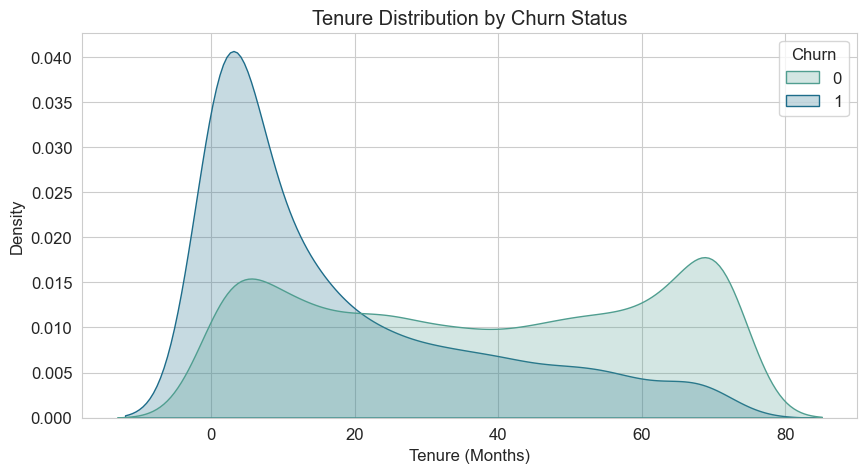

In [312]:
# Tenure vs Churn (KDE)
if {"tenure", "Churn"} <= set(df.columns):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=df,
        x="tenure",
        hue="Churn",
        fill=True,
        palette="crest",
        common_norm=False,
    )
    plt.title("Tenure Distribution by Churn Status")
    plt.xlabel("Tenure (Months)")
    plt.ylabel("Density")
    plt.show()

##### Observation: New customers (0-12 months) are at the highest risk of churning. Once a customer passes the 24-month mark, retention stabilizes.

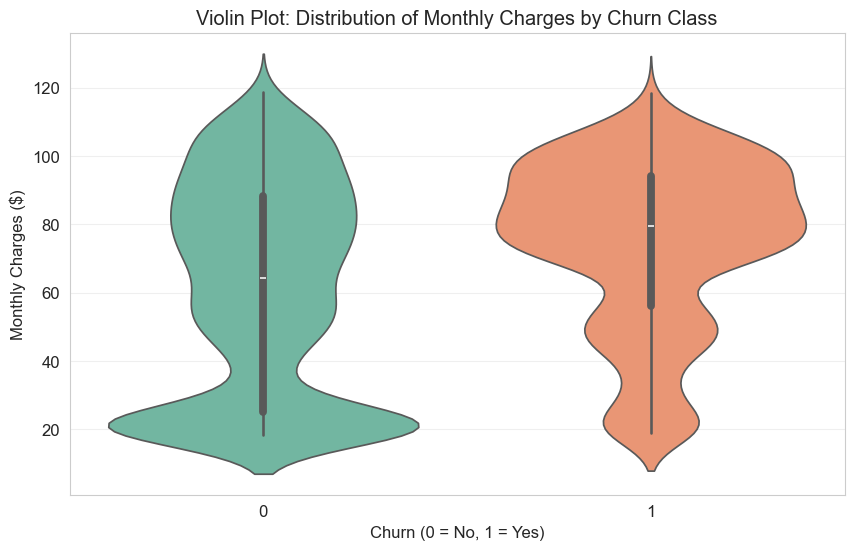

In [313]:
# Monthly Charges vs Churn
plt.figure(figsize=(10, 6))

sns.violinplot(x="Churn", y="MonthlyCharges", data=df, palette="Set2")

plt.title("Violin Plot: Distribution of Monthly Charges by Churn Class")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Monthly Charges ($)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Observation: Price Sensitivity

Non-Churners (0): The distribution is wider at the bottom (bulge near $20-$30), indicating a large base of happy customers on cheaper plans (likely DSL or simple phone service).

Churners (1): The violin shape is "top-heavy" (bulge near $70-$100). This clearly indicates that customers paying higher monthly fees are significantly more likely to churn. This suggests that expensive plans (like Fiber Optic) might not be delivering perceived value.

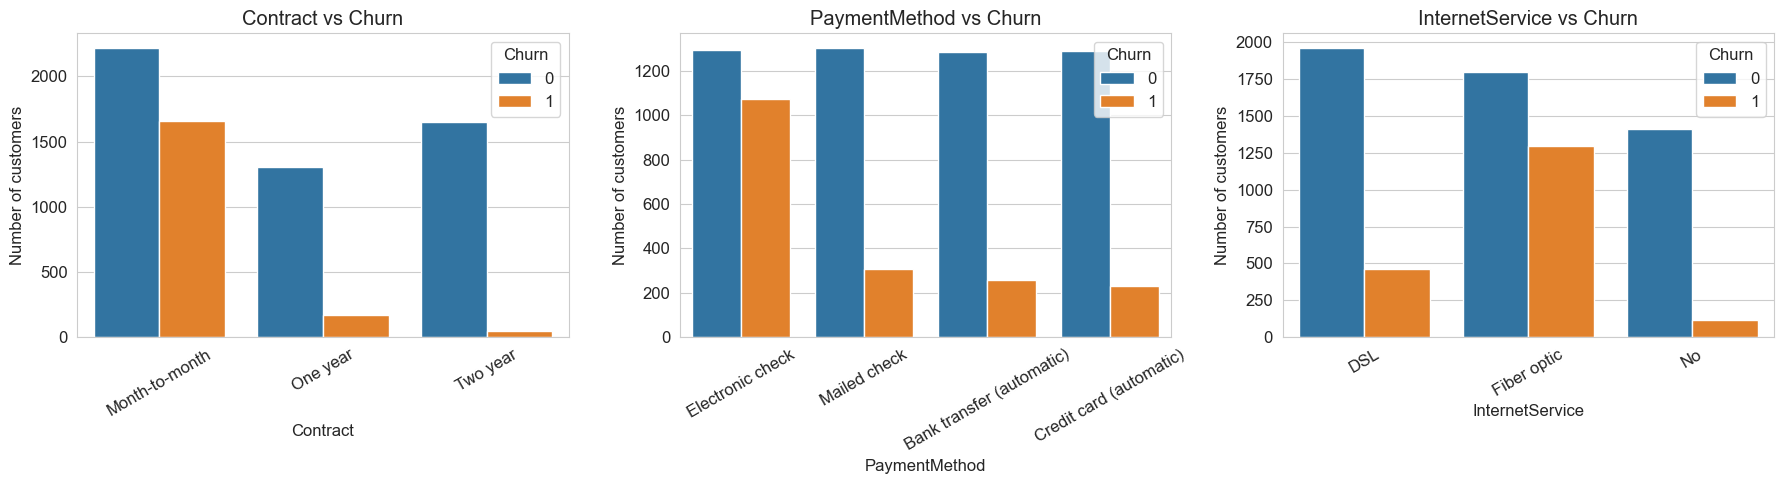


Mean values of key numerical features by Churn status:


,tenure,MonthlyCharges,TotalCharges
Churn,,,
0,37.57,61.27,2552.88
1,17.98,74.44,1531.80


In [314]:
# Numeric features vs Churn

important_cats = ["Contract", "PaymentMethod", "InternetService"]
important_cats = [c for c in important_cats if c in df.columns]

if important_cats:
    fig, axes = plt.subplots(1, len(important_cats), figsize=(6 * len(important_cats), 5))
    if len(important_cats) == 1:
        axes = [axes]

    for ax, col in zip(axes, important_cats):
        sns.countplot(data=df, x=col, hue="Churn", ax=ax)
        ax.set_title(f"{col} vs Churn")
        ax.set_xlabel(col)
        ax.set_ylabel("Number of customers")
        ax.tick_params(axis="x", rotation=30)

    plt.tight_layout()
    plt.show()

# Numeric means by Churn
if {"Churn"} <= set(df.columns):
    num_for_mean = [c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in df.columns]
    if num_for_mean:
        print("\nMean values of key numerical features by Churn status:")
        display(
            df.groupby("Churn")[num_for_mean]
              .mean()
              .round(2)
        )



Observation: Key Categorical Drivers of Churn

Contract Status: This is the most obvious predictor. Customers with Month-to-month contracts churn at an alarmingly high rate compared to those on One-year or Two-year contracts. Long-term contracts appear to lock customers in effectively.

Payment Method: Customers paying via Electronic Check have a significantly higher churn rate than any other payment method. This specific segment requires investigation—is the user interface for this payment method poor, or is it a demographic correlation?

Internet Service: Fiber Optic customers are much more likely to churn than DSL customers. Since Fiber Optic is usually more expensive, this suggests that customers might feel the service value does not match the high price point, or they are facing technical reliability issues.

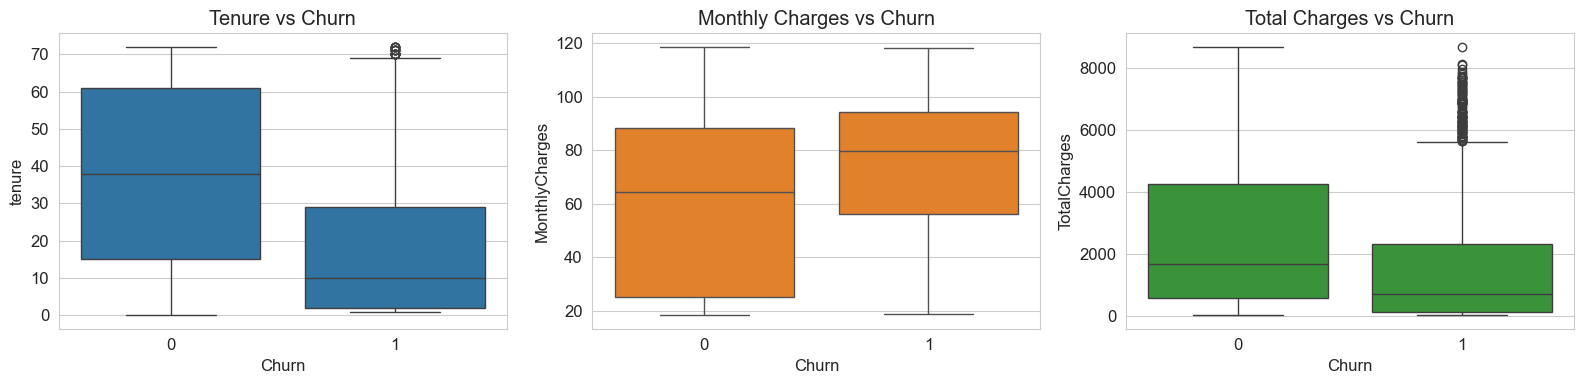

In [315]:
# Boxplots vs Churn
if all(c in df.columns for c in ["Churn", "tenure", "MonthlyCharges", "TotalCharges"]):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    sns.boxplot(x="Churn", y="tenure", data=df, ax=axes[0], palette=[colors[0], colors[0]])
    axes[0].set_title("Tenure vs Churn")

    sns.boxplot(
        x="Churn", y="MonthlyCharges", data=df, ax=axes[1], palette=[colors[1], colors[1]]
    )
    axes[1].set_title("Monthly Charges vs Churn")

    sns.boxplot(
        x="Churn", y="TotalCharges", data=df, ax=axes[2], palette=[colors[2], colors[2]]
    )
    axes[2].set_title("Total Charges vs Churn")

    plt.tight_layout()
    plt.show()



Observation: Numerical Features vs. Churn

Tenure: There is a strong negative relationship between tenure and churn.
    Churners (1): Have a much lower median tenure (around 10 months). The boxplot shows the majority of churn happens early in the customer lifecycle.
    Non-Churners (0): Have a much higher median tenure (~38 months). If a customer stays past the first year, they are significantly less likely to leave.

Monthly Charges: There is a positive relationship between cost and churn.
    Churners: Have a **higher average monthly charge (74.44)∗∗comparedtonon−churners(61.27). This indicates that higher-paying customers are the ones leaving, likely due to price sensitivity or competitive offers.
    
Total Charges: While the mean Total Charges for churners is lower ($1531 vs $2552), this is misleading. It is not because they pay less, but because they leave early (Low Tenure), preventing them from accumulating a high total bill. This confirms that TotalCharges is heavily dependent on tenure.

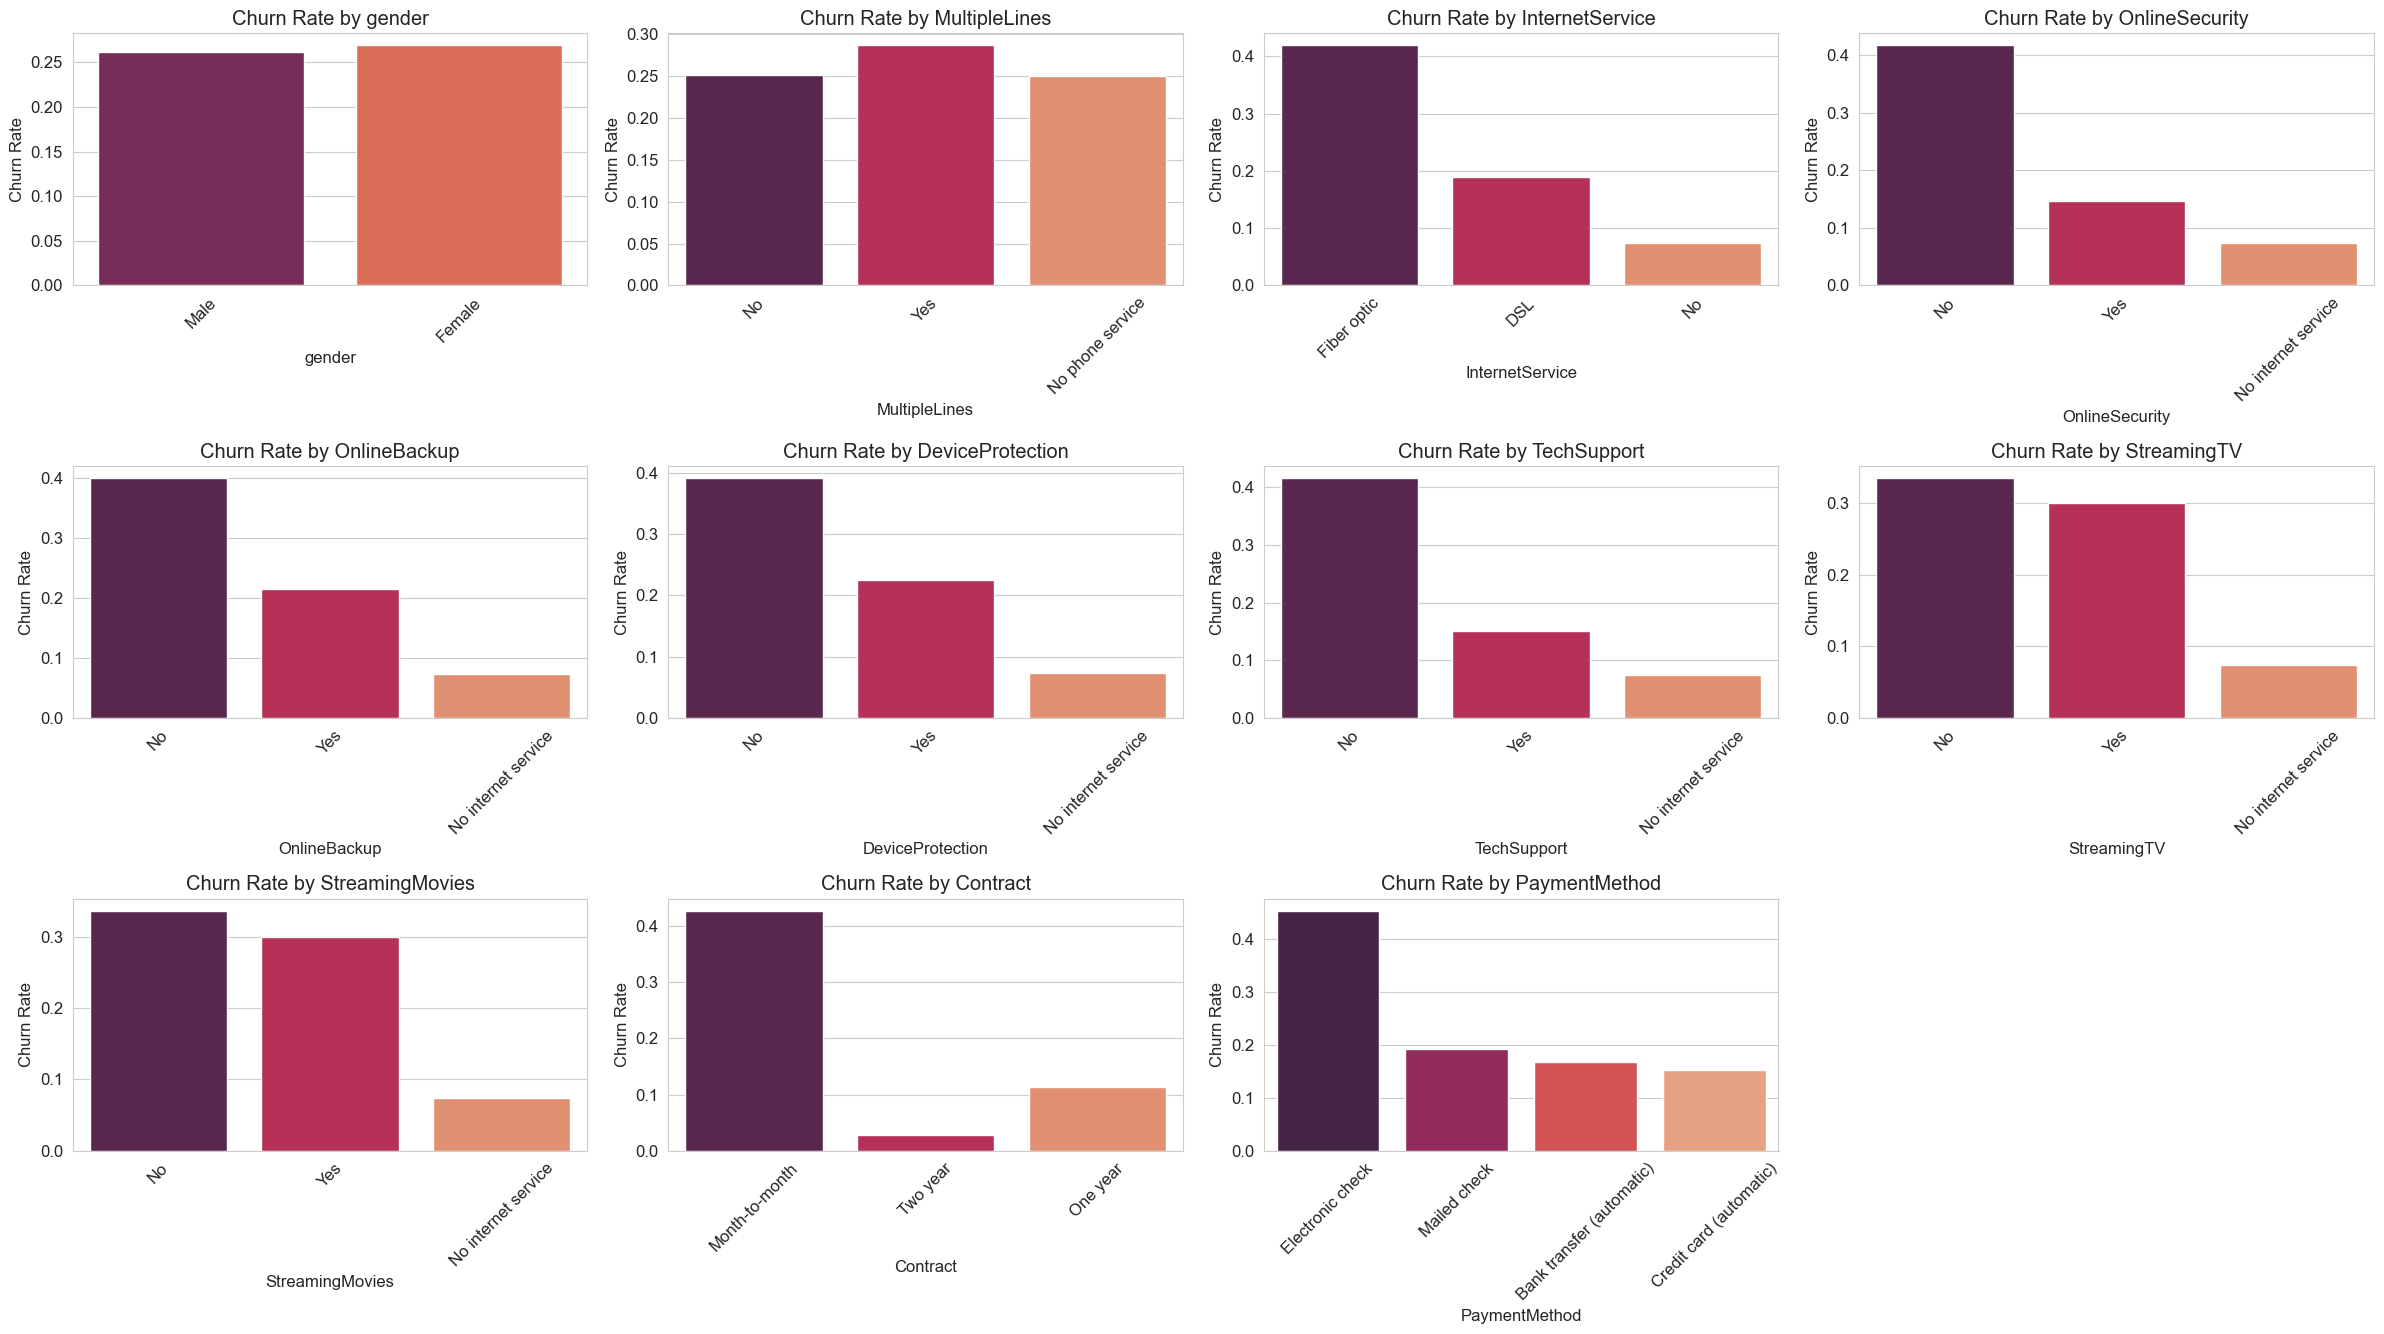

In [316]:
# Churn rate by category
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["Churn", "customerID"]]

if not cat_cols:
    print("No categorical columns to plot churn rate for.")
else:
    n_cols = 4
    n_features = len(cat_cols)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
    axes = np.array(axes).flatten()

    for i, col in enumerate(cat_cols):
        rate = (
            df.groupby(col)["Churn"]
              .value_counts(normalize=True)
              .rename("proportion")
              .reset_index()
        )
        churn_rate = rate[rate["Churn"] == 1]

        ax = axes[i]
        sns.barplot(
            data=churn_rate,
            x=col,
            y="proportion",
            order=df[col].value_counts().index,
            palette="rocket",
            ax=ax,
        )
        ax.set_title(f"Churn Rate by {col}")
        ax.set_ylabel("Churn Rate")
        ax.set_xlabel(col)
        ax.tick_params(axis="x", rotation=45)

    # remove unused axes
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


 Observation: Key Categorical Drivers
 
  Contract: This is the strongest predictor. 
  
  Month-to-month contracts have a ~43% churn rate, while 2-year contracts are near 0%. 
  
  Internet Service: Fiber Optic users churn significantly more than DSL users. 
  This indicates a potential problem with Fiber service quality or pricing. 
  
  Payment Method: Users paying via Electronic Check churn at a much higher rate than those using automated bank transfers or credit cards.
  
  Support Services: Customers without Tech Support or Online Security are highly vulnerable to churning.

##### Multivariate analysis

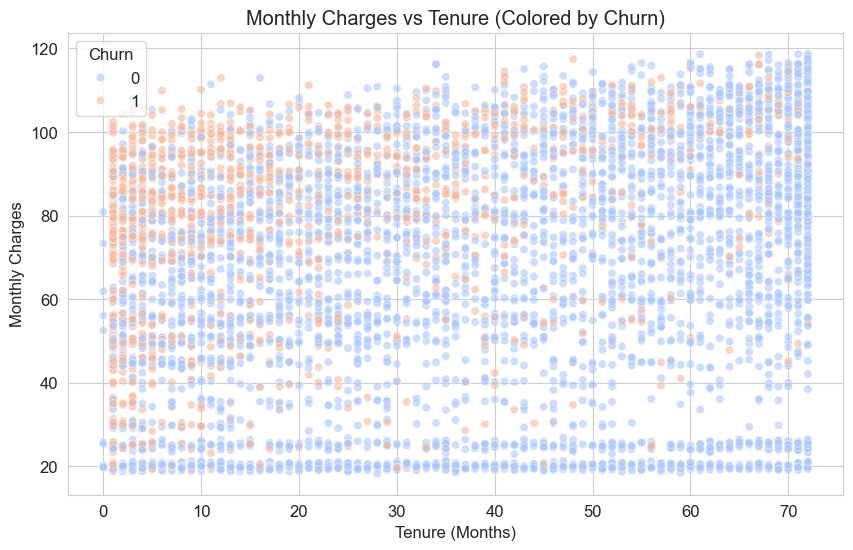

In [317]:
#  Tenure vs MonthlyCharges coloured by Churn

if {"tenure", "MonthlyCharges", "Churn"} <= set(df.columns):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="tenure",
        y="MonthlyCharges",
        hue="Churn",
        alpha=0.6,
        palette="coolwarm",
    )
    plt.title("Monthly Charges vs Tenure (Colored by Churn)")
    plt.xlabel("Tenure (Months)")
    plt.ylabel("Monthly Charges")
    plt.show()


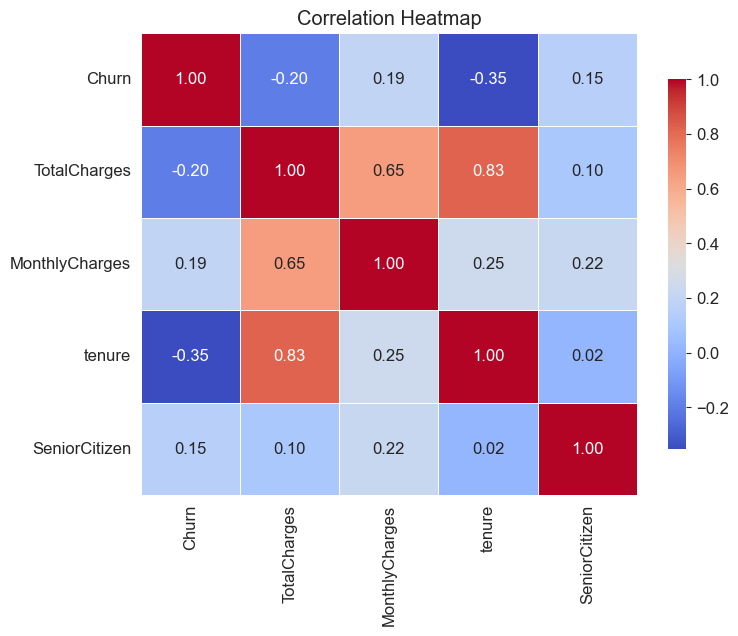

In [318]:
# Select only the required columns
corr_cols = ["Churn", "TotalCharges", "MonthlyCharges", "tenure", "SeniorCitizen"]

# Filter dataframe for these columns only
corr_df = df[corr_cols]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap")
plt.show()


Observation: Correlations

Multicollinearity: TotalCharges and tenure have a correlation of 0.82. This is redundant. In linear models (like Logistic Regression), we should remove TotalCharges to reduce noise.

Churn Correlations:
Positive Correlation: MonthlyCharges (Higher price = Higher Churn).
Negative Correlation: tenure and Contract (Longer stay/Longer contract = Lower Churn).

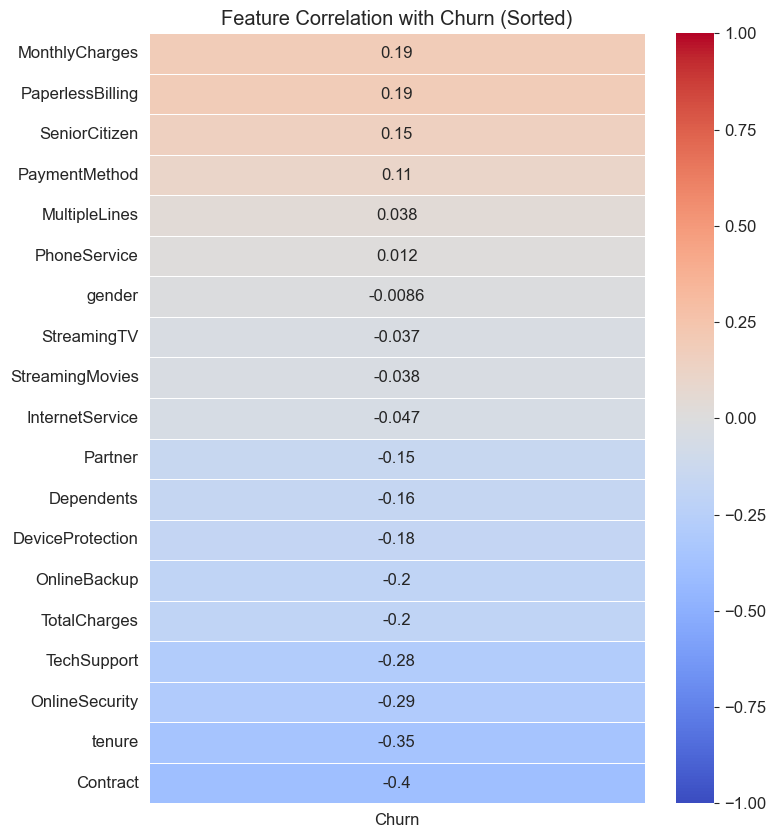

In [319]:
# Correlation with Target (Churn)

# A copy to encode categorical variables for correlation analysis
df_corr = df.copy()

# Encode categorical columns to numeric codes just for this plot
for col in df_corr.columns:
    if df_corr[col].dtype == 'object' or df_corr[col].dtype.name == 'category':
        df_corr[col] = df_corr[col].astype('category').cat.codes

# Calculate correlation with Churn and sort it
churn_correlation = df_corr.corr()[['Churn']].sort_values(by='Churn', ascending=False)

# Remove the self-correlation (Churn vs Churn = 1)
churn_correlation = churn_correlation.drop('Churn')

# Plot
plt.figure(figsize=(8, 10))
sns.heatmap(churn_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation with Churn (Sorted)")
plt.show()

Observation: Correlation Analysis

Positive Correlation (Red - Factors that increase Churn):

    Monthly Charges: As seen in the violin plot, higher costs correlate with higher churn.
    Paperless Billing: Surprisingly, users with paperless billing show a higher tendency to churn.
    Senior Citizen: Older demographics have a slight positive correlation with churn.
    
Negative Correlation (Blue - Factors that decrease Churn):

    Contract: This is the strongest negative correlation. Longer contracts strongly reduce churn.
    Tenure: Highly negative. The longer a customer stays, the less likely they are to leave.
    Total Charges: Negative correlation, but this is largely because TotalCharges is mathematically tied to Tenure.

## 5. FEATURE ENGINEERING

In [320]:
# 5.1 Tenure Grouping
df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[-1, 12, 24, 48, 72, np.inf],
    labels=["0-12", "13-24", "25-48", "49-72", "73+"],
    include_lowest=True
)

# 5.2 Interaction & Log Features
df['Log_TotalCharges'] = np.log1p(df['TotalCharges'])
df['Log_MonthlyCharges'] = np.log1p(df['MonthlyCharges'])
df['Monthly_to_Total_Ratio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)

# 5.3 Service Counters
# Helper to treat "Yes" as 1, everything else ("No", "No internet service") as 0
def service_flag(v):
    if v == 1 or v == 'Yes': return 1
    return 0

service_cols = [
    "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]
existing_svc = [c for c in service_cols if c in df.columns]

# Use apply with map, or vectorized replace for speed. applymap is deprecated.
# We create a temporary dataframe where everything is mapped to 0/1 for summation
svc_binary = df[existing_svc].apply(lambda x: x.map(service_flag))
df["total_services"] = svc_binary.sum(axis=1)

# Streaming specific
streaming_cols = [c for c in ["StreamingTV", "StreamingMovies"] if c in df.columns]
if streaming_cols:
    df["streaming_services"] = df[streaming_cols].apply(lambda x: x.map(service_flag)).sum(axis=1)

# 5.4 Auto Pay
if "PaymentMethod" in df.columns:
    df["is_auto_pay"] = df["PaymentMethod"].str.contains("automatic", case=False).astype(int)

print("Feature Engineering complete.")

Feature Engineering complete.


## 6. STATISTICAL TESTS 

In [321]:
# Chi-square tests for categorical features vs Churn
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "Churn"]

chi2_results = []
for col in cat_cols:
    contingency = pd.crosstab(df[col], df["Churn"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results.append({"feature": col, "p_value": p})

chi2_df = (
    pd.DataFrame(chi2_results)
      .sort_values("p_value")
      .reset_index(drop=True)
)

print("\nChi-square test p-values (categorical features vs Churn):")
display(chi2_df)


Chi-square test p-values (categorical features vs Churn):


,feature,p_value
0,Contract,5.863038e-258
1,OnlineSecurity,2.661150e-185
2,TechSupport,1.443084e-180
3,InternetService,9.571788e-160
4,PaymentMethod,3.682355e-140
5,OnlineBackup,2.079759e-131
6,DeviceProtection,5.505219e-122
7,StreamingMovies,2.667757e-82
8,StreamingTV,5.528994e-82
9,MultipleLines,3.464383e-03


In [322]:
# T-tests for numeric features vs Churn
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["Churn"]]

ttest_results = []
churn_yes = df[df["Churn"] == 1]
churn_no = df[df["Churn"] == 0]

for col in numeric_cols:
    t_stat, p = ttest_ind(churn_yes[col], churn_no[col], equal_var=False)
    ttest_results.append({"feature": col, "p_value": p})

ttest_df = pd.DataFrame(ttest_results).sort_values("p_value")

print("\nT-test p-values (numeric features vs Churn):")
display(ttest_df)


T-test p-values (numeric features vs Churn):


,feature,p_value
3,tenure,1.195495e-232
10,Monthly_to_Total_Ratio,1.189976e-100
9,Log_MonthlyCharges,2.281461e-93
8,Log_TotalCharges,3.690573e-81
13,is_auto_pay,7.452631e-78
7,TotalCharges,2.059075e-75
6,MonthlyCharges,8.592449e-73
5,PaperlessBilling,4.802979e-66
2,Dependents,9.878649e-53
1,Partner,7.980266e-38


## 7. SAVE PREPROCESSED DATASET

In [323]:
os.makedirs("preprocessed_dataset", exist_ok=True)
output_path = "preprocessed_dataset/preprocessed_data.csv"
df.to_csv(output_path, index=False)

print("\nPreprocessing complete!")
print(f"Saved cleaned + feature-engineered dataset to:\n{output_path}")


Preprocessing complete!
Saved cleaned + feature-engineered dataset to:
preprocessed_dataset/preprocessed_data.csv
